In [9]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [10]:
# Basics
import tensorflow as tf
import xarray as xr
import random

# Helpful
import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
from src.models.EMOS_local.EMOS_local_load_score import *  # Load EMOS_local_scores
from src.models.EMOS_local.EMOS_local_load_model import *  # Load EMOS_local_models
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.DRN.DRN_load_score import *  # Load DRN_scores
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores

<IPython.core.display.Javascript object>

### 0. Setup

### 1. Load Scores

In [11]:
# Baseline Scores
CRPS_baseline_scores_t2m = crps_load_lead_lat_lon("t2m")
CRPS_baseline_scores_ws10 = crps_load_lead_lat_lon("ws10")

# Global Scores:
EMOS_glob_scores_t2m = EMOS_global_load_score("t2m")
EMOS_glob_scores_ws10 = EMOS_global_load_score("ws10")

# Local Scores:
EMOS_loc_scores_t2m = EMOS_local_load_score("t2m")
EMOS_loc_scores_ws10 = EMOS_local_load_score("ws10")

DRN_scores_t2m = DRN_load_score("t2m")
DRN_scores_ws10 = DRN_load_score("ws10")
# All same shape: len(31) -> shape (31, 120, 130)

<IPython.core.display.Javascript object>

### 2.. Diagram Comparison

In [12]:
def bar_chart_all_scores(var_name, binned=False, models=[True, True, True, True]):
    """
    Plot a bar chart with all of the mean scores over the lead_times. Either binned or not
    Args:
        var_name (str): Variable name to use for comparison
        binned (bool): Whether to bin the lead_times together in bins of 5 or not
        models (list): Which models to add to the graph. 
    Returns:
        None
    """
    # Load all scores
    load_funcs = [
        crps_load_lead_lat_lon,
        EMOS_global_load_score,
        EMOS_local_load_score,
        DRN_load_score,
    ]
    all_scores = []
    for count, boolean in enumerate(models):
        if boolean:
            all_scores.append(load_funcs[count](var_name))
    
    # All same shape: (31, 120, 130)
    # Making mean scores:
    all_scores_mean = []
    all_scores_mean_binned = []
    for model in range(len(all_scores)):
        all_scores_mean.append([])
        for lead_time in range(31):
            all_scores_mean[model].append(all_scores[model][lead_time].mean())

    for model in range(len(all_scores)):
        if binned:
            chunks = [all_scores_mean[model][i : i + 5] for i in range(0, 25, 5)] + [
                all_scores_mean[model][-6:]
            ]
            all_scores_mean_binned.append([np.mean(chunk) for chunk in chunks])

    # Deciding on which scores to use:
    if binned:
        model_scores = all_scores_mean_binned
        N = 6
    else:
        model_scores = all_scores_mean
        N = 31

    # Plotting bar charts
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    labels_all = ["CRPS_baseline", "EMOS_glob", "EMOS_loc", "DRN"]
    colors_all = ['yellow', "green", "blue", 'red']
    
    labels_models = []
    colors_models = []
    for count, boolean in enumerate(models):
        if boolean:
            labels_models.append(labels_all[count])
            colors_models.append(colors_all[count])

    # Iterate through lead times
    for lead_time in ind:
        # Create a list of tuples (score, label, model_index, color) for current lead time
        scores_with_labels = [(model_scores[model_index][lead_time], labels_models[model_index], model_index, colors_models[model_index])
                              for model_index in range(len(labels_models))]

        # Sort scores_with_labels in descending order
        scores_with_labels.sort(reverse=True)

        # Draw a bar for each model starting with the highest score
        for score, label, model_index, color in scores_with_labels:
            ax.bar(lead_time, score, width, color=color, label=f"{label}" if lead_time == 0 else "")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Lead_time")
    ax.set_title("Scores by Array and Index")
    ax.set_xticks(ind)
    ax.set_xticklabels([str(i) for i in range(N)])
    plt.xticks(rotation=60)
    ax.legend()

    plt.show()


<IPython.core.display.Javascript object>

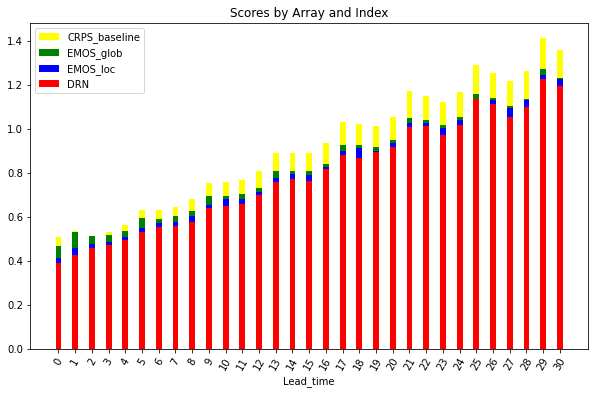

<IPython.core.display.Javascript object>

In [13]:
bar_chart_all_scores("t2m", binned=False)

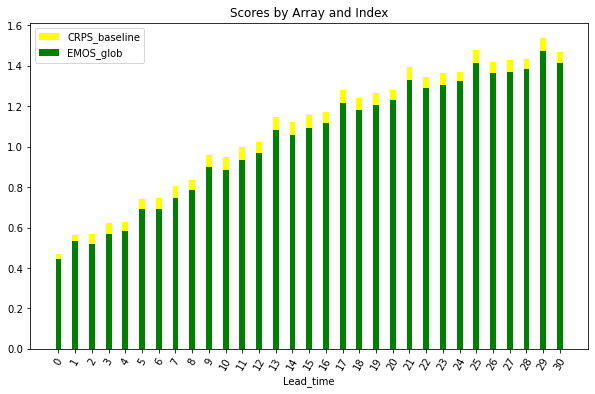

<IPython.core.display.Javascript object>

In [14]:
bar_chart_all_scores("ws10", binned=False, models=[True, True, False, False])

### 3. Maps

In [18]:
def heatmap_lead(var_name, lead_time, models=[True, True, True, True]):
    """
    Plots the specified number of heatmaps of the scores for a specified lead time
Args:
    var_name (str): variable to use 
    lead_time (int): Lead time 0 - 30
    models (list): Boolean list determining which models to plot
Returns:
    None
    """
    # Load lead_time specific scores
    load_funcs = [
        crps_load_lead_lat_lon,
        EMOS_global_load_score,
        EMOS_local_load_score,
        DRN_load_score,
    ]
    all_mean_scores = []
    for count, boolean in enumerate(models):
        if boolean:
            all_mean_scores.append(load_funcs[count](var_name)[lead_time])
    # All same shape: 120x130

    # Decide on labels
    labels_all = ["CRPS_baseline", "EMOS_glob", "EMOS_loc", "DRN"]
    labels_models = []
    for count, boolean in enumerate(models):
        if boolean:
            labels_models.append(labels_all[count])

    # Find global min and max across all datasets
    vmin = np.min([np.min(scores) for scores in all_mean_scores])
    vmax = np.max([np.max(scores) for scores in all_mean_scores])

    # Plot heat maps
    fig, axs = plt.subplots(len(all_mean_scores), 1, figsize=(25, 15))
    for model in range(len(all_mean_scores)):
        im = axs[model].imshow(
            all_mean_scores[model], cmap="viridis", vmin=vmin, vmax=vmax
        )
        fig.colorbar(
            im, ax=axs[model], label="your label"
        )  # add colorbar to the figure and associate it with the axis
        axs[model].set_title(
            f"Colormap {labels_models[model]} score, lead_time {lead_time}"
        )
    plt.show()

<IPython.core.display.Javascript object>

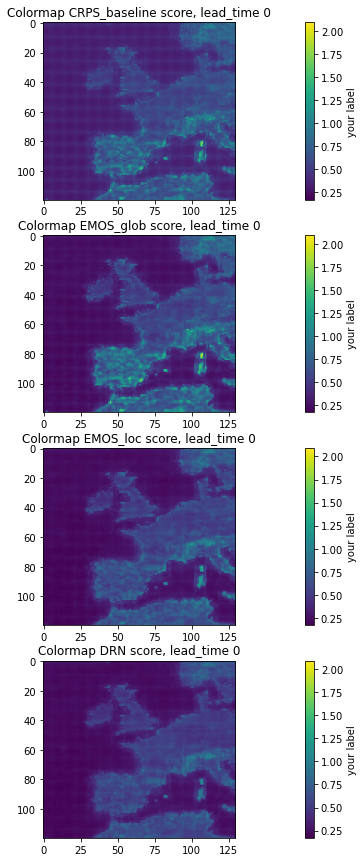

<IPython.core.display.Javascript object>

In [19]:
heatmap_lead("t2m", 0)

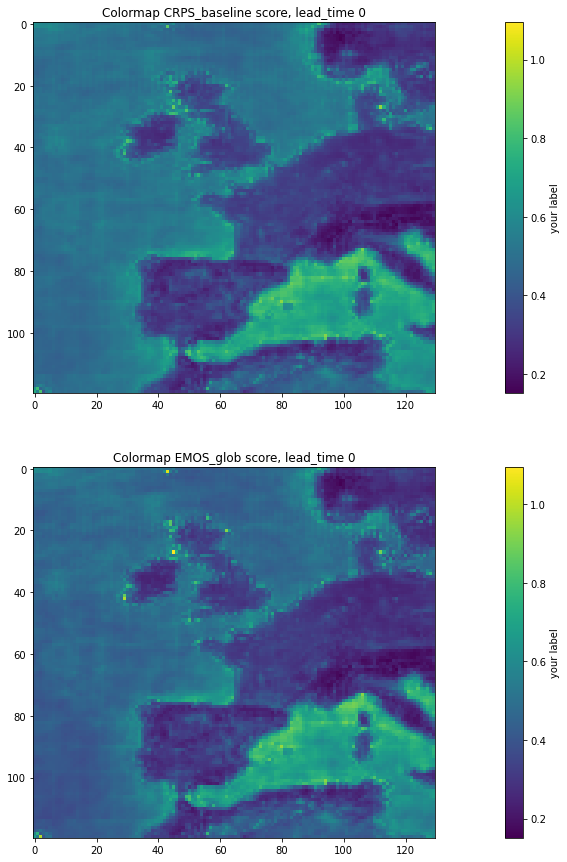

<IPython.core.display.Javascript object>

In [21]:
heatmap_lead("ws10", 0, models=[True, True, False, False])

### 4. Boxplots

#### 4.1 Boxplot all lead_times

In [18]:
def box_plot_all_scores(var_name, binned=False, models=[True, True, True, True]):
    """
    Plot a box plot with all of the scores over the lead_times. Either binned or not
Args:
    var_name (str): Variable name to use for comparison
    binned (bool): Whether to bin the lead_times together in bins of 5 or not
    models (list): Which models to add to the graph. 
Returns: 
    None
    """
    # Load all scores
    load_funcs = [
        crps_load_lead_lat_lon,
        EMOS_global_load_score,
        EMOS_local_load_score,
        DRN_load_score,
    ]
    all_scores = []
    for count, boolean in enumerate(models):
        if boolean:
            all_scores.append(load_funcs[count](var_name))
    # All same shape: (31, 120, 130)

    # Making mean scores:
    all_scores_mean = []
    all_scores_mean_binned = []
    for model in range(len(all_scores)):
        all_scores_mean.append([])
        for lead_time in range(31):
            all_scores_mean[model].append(all_scores[model][lead_time].mean())

    for model in range(len(all_scores)):
        if binned:
            chunks = [all_scores_mean[model][i : i + 5] for i in range(0, 25, 5)] + [
                all_scores_mean[model][-6:]
            ]
            all_scores_mean_binned.append([np.mean(chunk) for chunk in chunks])

    # Deciding on which scores to use:
    if binned:
        model_scores = all_scores_mean_binned
        N = 6
    else:
        model_scores = all_scores_mean
        N = 31

    # Deciding on which labels to use
    labels_all = ["CRPS_baseline", "EMOS_glob", "EMOS_loc", "DRN"]
    labels_models = []

    for count, boolean in enumerate(models):
        if boolean:
            labels_models.append(labels_all[count])

    # Plotting box plots
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.boxplot(model_scores, labels=labels_models, notch=False)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Models")
    ax.set_title("Scores by Array and Index")
    ax.set_xticklabels(labels_models)
    plt.xticks(rotation=60)

    plt.show()

<IPython.core.display.Javascript object>

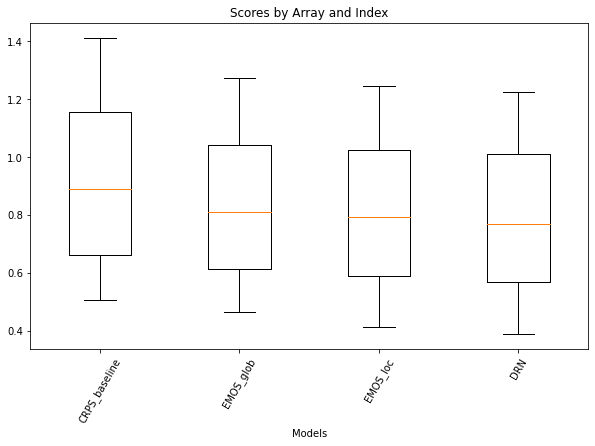

<IPython.core.display.Javascript object>

In [19]:
box_plot_all_scores("t2m")

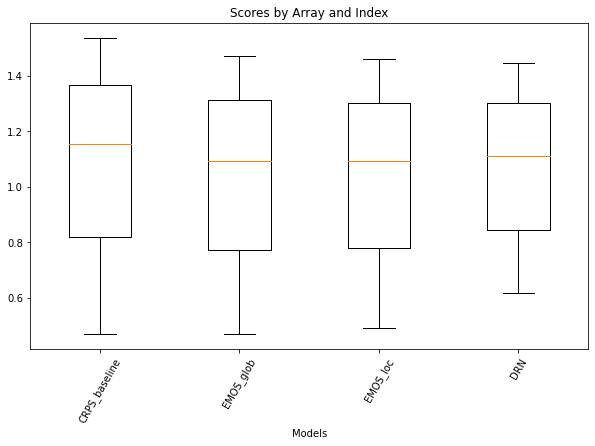

<IPython.core.display.Javascript object>

In [20]:
box_plot_all_scores("ws10", models=[True, True, True, True])

#### 4.2 Boxplot one lead_time

In [21]:
def box_plot_lead_time_scores(var_name, lead_time, models=[True, True, True, True]):
    """
    Plot a box plot with all of the scores over one lead_time. Either binned or not
Args:
    var_name (str): Variable name to use for comparison
    lead_time(int): Between 0 - 30, decided which lead_time to use.
    models (list): Which models to add to the graph. 
Returns:
    None
    """
    # Load lead_time specific scores
    load_funcs = [
        crps_load_lead_lat_lon,
        EMOS_global_load_score,
        EMOS_local_load_score,
        DRN_load_score,
    ]
    all_mean_scores = []
    for count, boolean in enumerate(models):
        if boolean:
            all_mean_scores.append(load_funcs[count](var_name)[lead_time].flatten())
    # All same shape: 120x130

    # Deciding on which labels to use
    labels_all = ["CRPS_baseline", "EMOS_glob", "EMOS_loc", "DRN"]
    labels_models = []

    for count, boolean in enumerate(models):
        if boolean:
            labels_models.append(labels_all[count])

    # Plotting box plots
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.boxplot(all_mean_scores, labels=labels_models, notch=True)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Models")
    ax.set_title(f"Scores, lead_time {lead_time}")
    ax.set_xticklabels(labels_models)
    plt.xticks(rotation=60)

    plt.show()

<IPython.core.display.Javascript object>

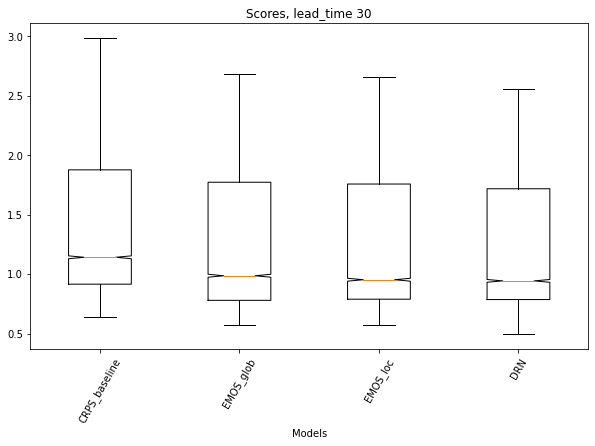

<IPython.core.display.Javascript object>

In [22]:
box_plot_lead_time_scores("t2m", 30)

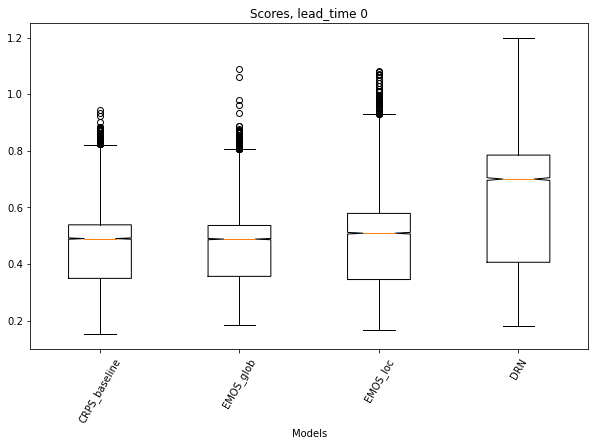

<IPython.core.display.Javascript object>

In [26]:
box_plot_lead_time_scores("ws10", 0, models=[True, True, True, True])